# 1.判断多边形能否平铺


In [2]:

""" 
内角和必须是360度的整数倍
边长必须能够匹配（相邻边能够完全贴合）
顶点处的角度和必须是360度的整数倍
"""

import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

def is_polygon_tiled(polygon, tile_size):
    """
    判断多边形能否平铺
    参数:
        polygon: shapely.Polygon对象
        tile_size: 平铺区域的大小
    返回:
        bool: 是否可以平铺
    """
    # 获取多边形的坐标
    coords = list(polygon.exterior.coords)
    
    # 计算内角和
    n = len(coords) - 1  # 顶点数
    angles = []
    for i in range(n):
        p1 = np.array(coords[i])
        p2 = np.array(coords[(i+1)%n])
        p3 = np.array(coords[(i+2)%n])
        
        # 计算两个向量
        v1 = p1 - p2
        v2 = p3 - p2
        
        # 计算角度（弧度）
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(angle)
    
    # 内角和检查
    internal_sum = sum(angles)
    expected_sum = (n-2) * np.pi  # 多边形内角和应该是 (n-2)*180°
    
    if not np.isclose(internal_sum, expected_sum, rtol=1e-10):
        return False
    
    # 检查边长是否匹配
    edges = []
    for i in range(n):
        edge = np.linalg.norm(np.array(coords[i]) - np.array(coords[(i+1)%n]))
        edges.append(edge)
    
    # 检查是否存在可以匹配的边（长度相等）
    for i in range(n):
        if not any(np.isclose(edges[i], edges[j], rtol=1e-10) for j in range(i+1, n)):
            return False
    
    return True



# 2. 采用monte carlo方法生成不能平铺的多边形


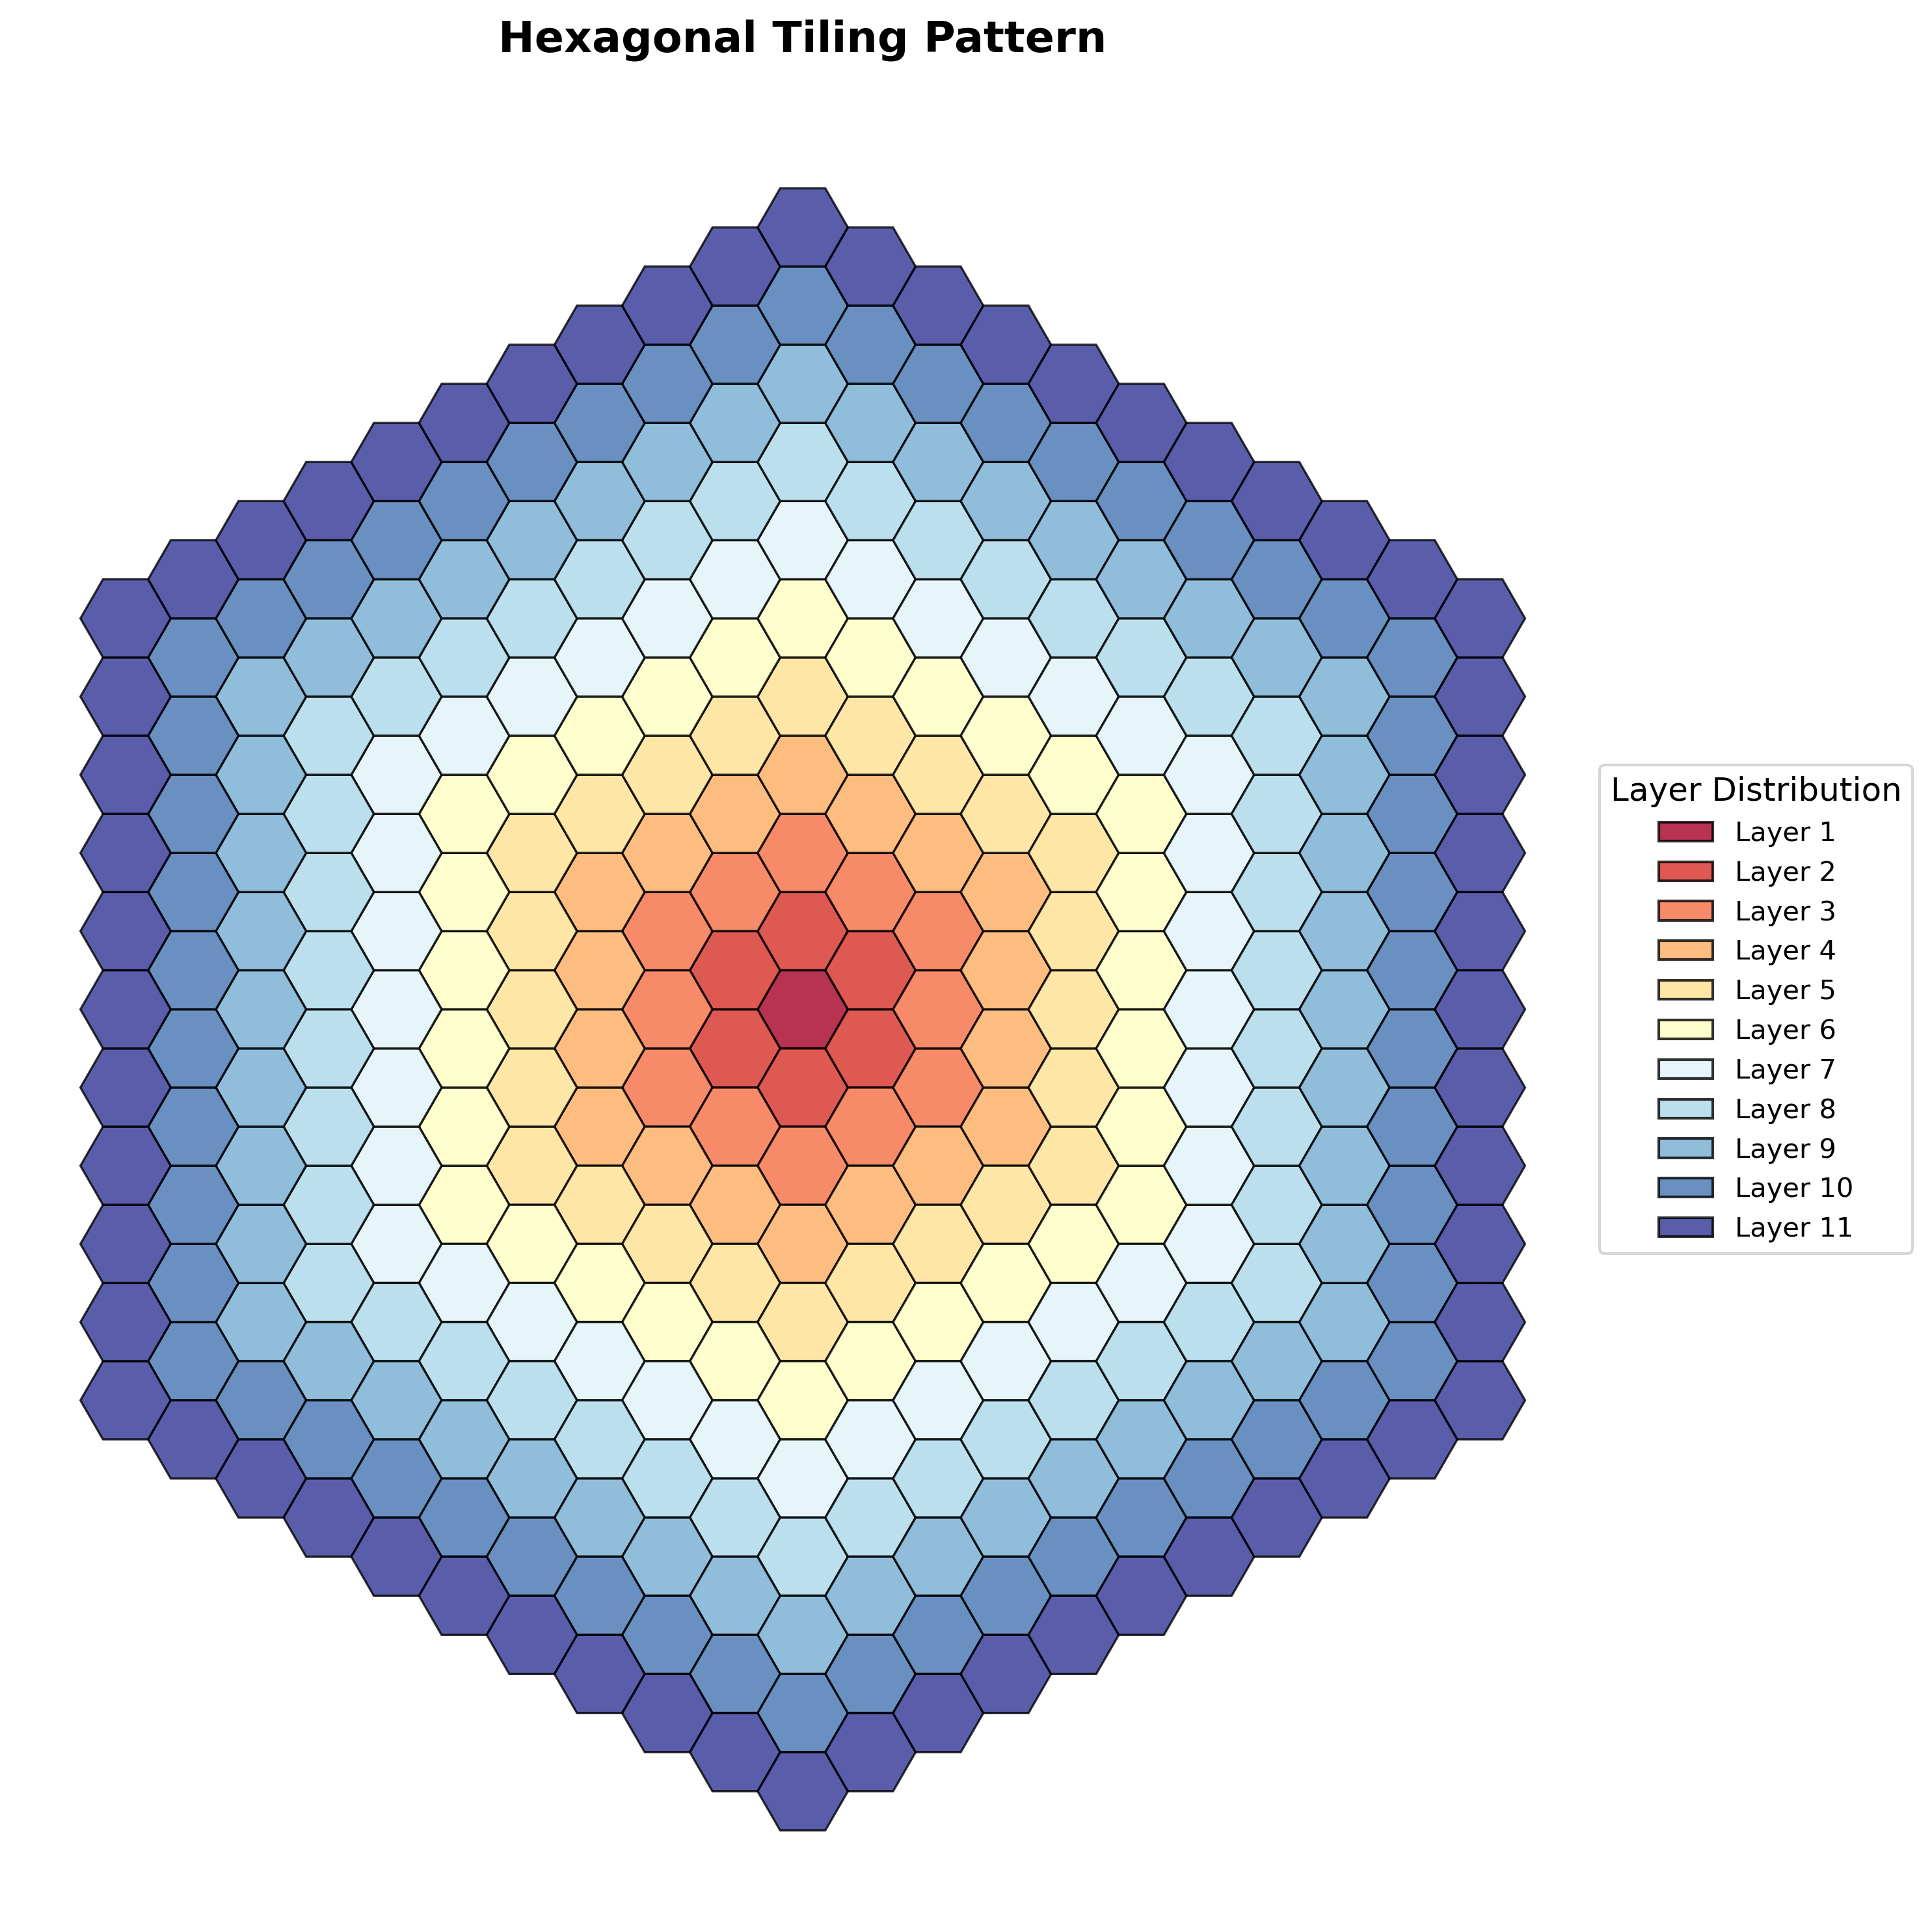

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def create_hexagon(radius=1):
    """Create a single hexagon centered at the origin."""
    angles = np.linspace(0, 2 * np.pi, 7)[:-1]  # 6 points
    return np.array([[np.cos(a) * radius, np.sin(a) * radius] for a in angles])

def generate_colored_hexagonal_tiling(radius, layers):
    """Generate a hexagonal tiling with a specific color for each layer."""
    hexagons_by_layer = []

    for layer in range(layers + 1):
        layer_hexagons = []
        # 只生成当前层的六边形（而不是从中心到当前层的所有六边形）
        if layer == 0:
            # 中心六边形
            layer_hexagons.append(create_hexagon(radius))
        else:
            # 对于每一层，生成完整的六边形层
            for q in range(-layer, layer + 1):
                for r in range(-layer, layer + 1):
                    # 修改条件以生成完整的六边形层
                    if max(abs(q), abs(r), abs(-q-r)) == layer:
                        x_offset = radius * 3 / 2 * q
                        y_offset = radius * np.sqrt(3) * (r + q / 2)
                        layer_hexagons.append(create_hexagon(radius) + [x_offset, y_offset])
        
        hexagons_by_layer.append(layer_hexagons)

    return hexagons_by_layer

def visualize_colored_hexagonal_tiling(hexagons_by_layer):
    """Visualize the hexagonal tiling with different colors for each layer."""
    # 创建更大的图形,增加DPI以提高清晰度
    plt.figure(figsize=(10, 10), dpi=300)
    
    # 使用更专业的配色方案
    colors = plt.cm.RdYlBu(np.linspace(0, 1, len(hexagons_by_layer)))

    # 绘制六边形
    for layer_idx, layer_hexagons in enumerate(hexagons_by_layer):
        for hexagon in layer_hexagons:
            plt.fill(hexagon[:, 0], hexagon[:, 1], 
                    color=colors[layer_idx],
                    edgecolor='black',
                    linewidth=0.8,
                    alpha=0.8)  # 添加透明度

    # 设置坐标轴
    plt.axis('equal')
    plt.axis('off')
    
    # 添加标题和说明
    plt.title('Hexagonal Tiling Pattern', 
              fontsize=16, 
              pad=20,
              fontweight='bold')
    
    # 添加图例
    legend_elements = [plt.Rectangle((0, 0), 1, 1, 
                                   facecolor=colors[i], 
                                   edgecolor='black',
                                   alpha=0.8,
                                   label=f'Layer {i+1}') 
                      for i in range(len(hexagons_by_layer))]
    plt.legend(handles=legend_elements, 
              loc='center left', 
              bbox_to_anchor=(1, 0.5),
              title='Layer Distribution',
              title_fontsize=12,
              fontsize=10)
    
    # 调整布局以适应图例
    plt.tight_layout()
    
    # 保存高质量图片
    plt.savefig('hexagonal_tiling.png', 
                dpi=300, 
                bbox_inches='tight',
                pad_inches=0.1)
    
    plt.show()

# 生成六边形平铺图案
radius = 1
layers = 10  # 层数
hexagons_by_layer = generate_colored_hexagonal_tiling(radius, layers)

# 可视化结果
visualize_colored_hexagonal_tiling(hexagons_by_layer)


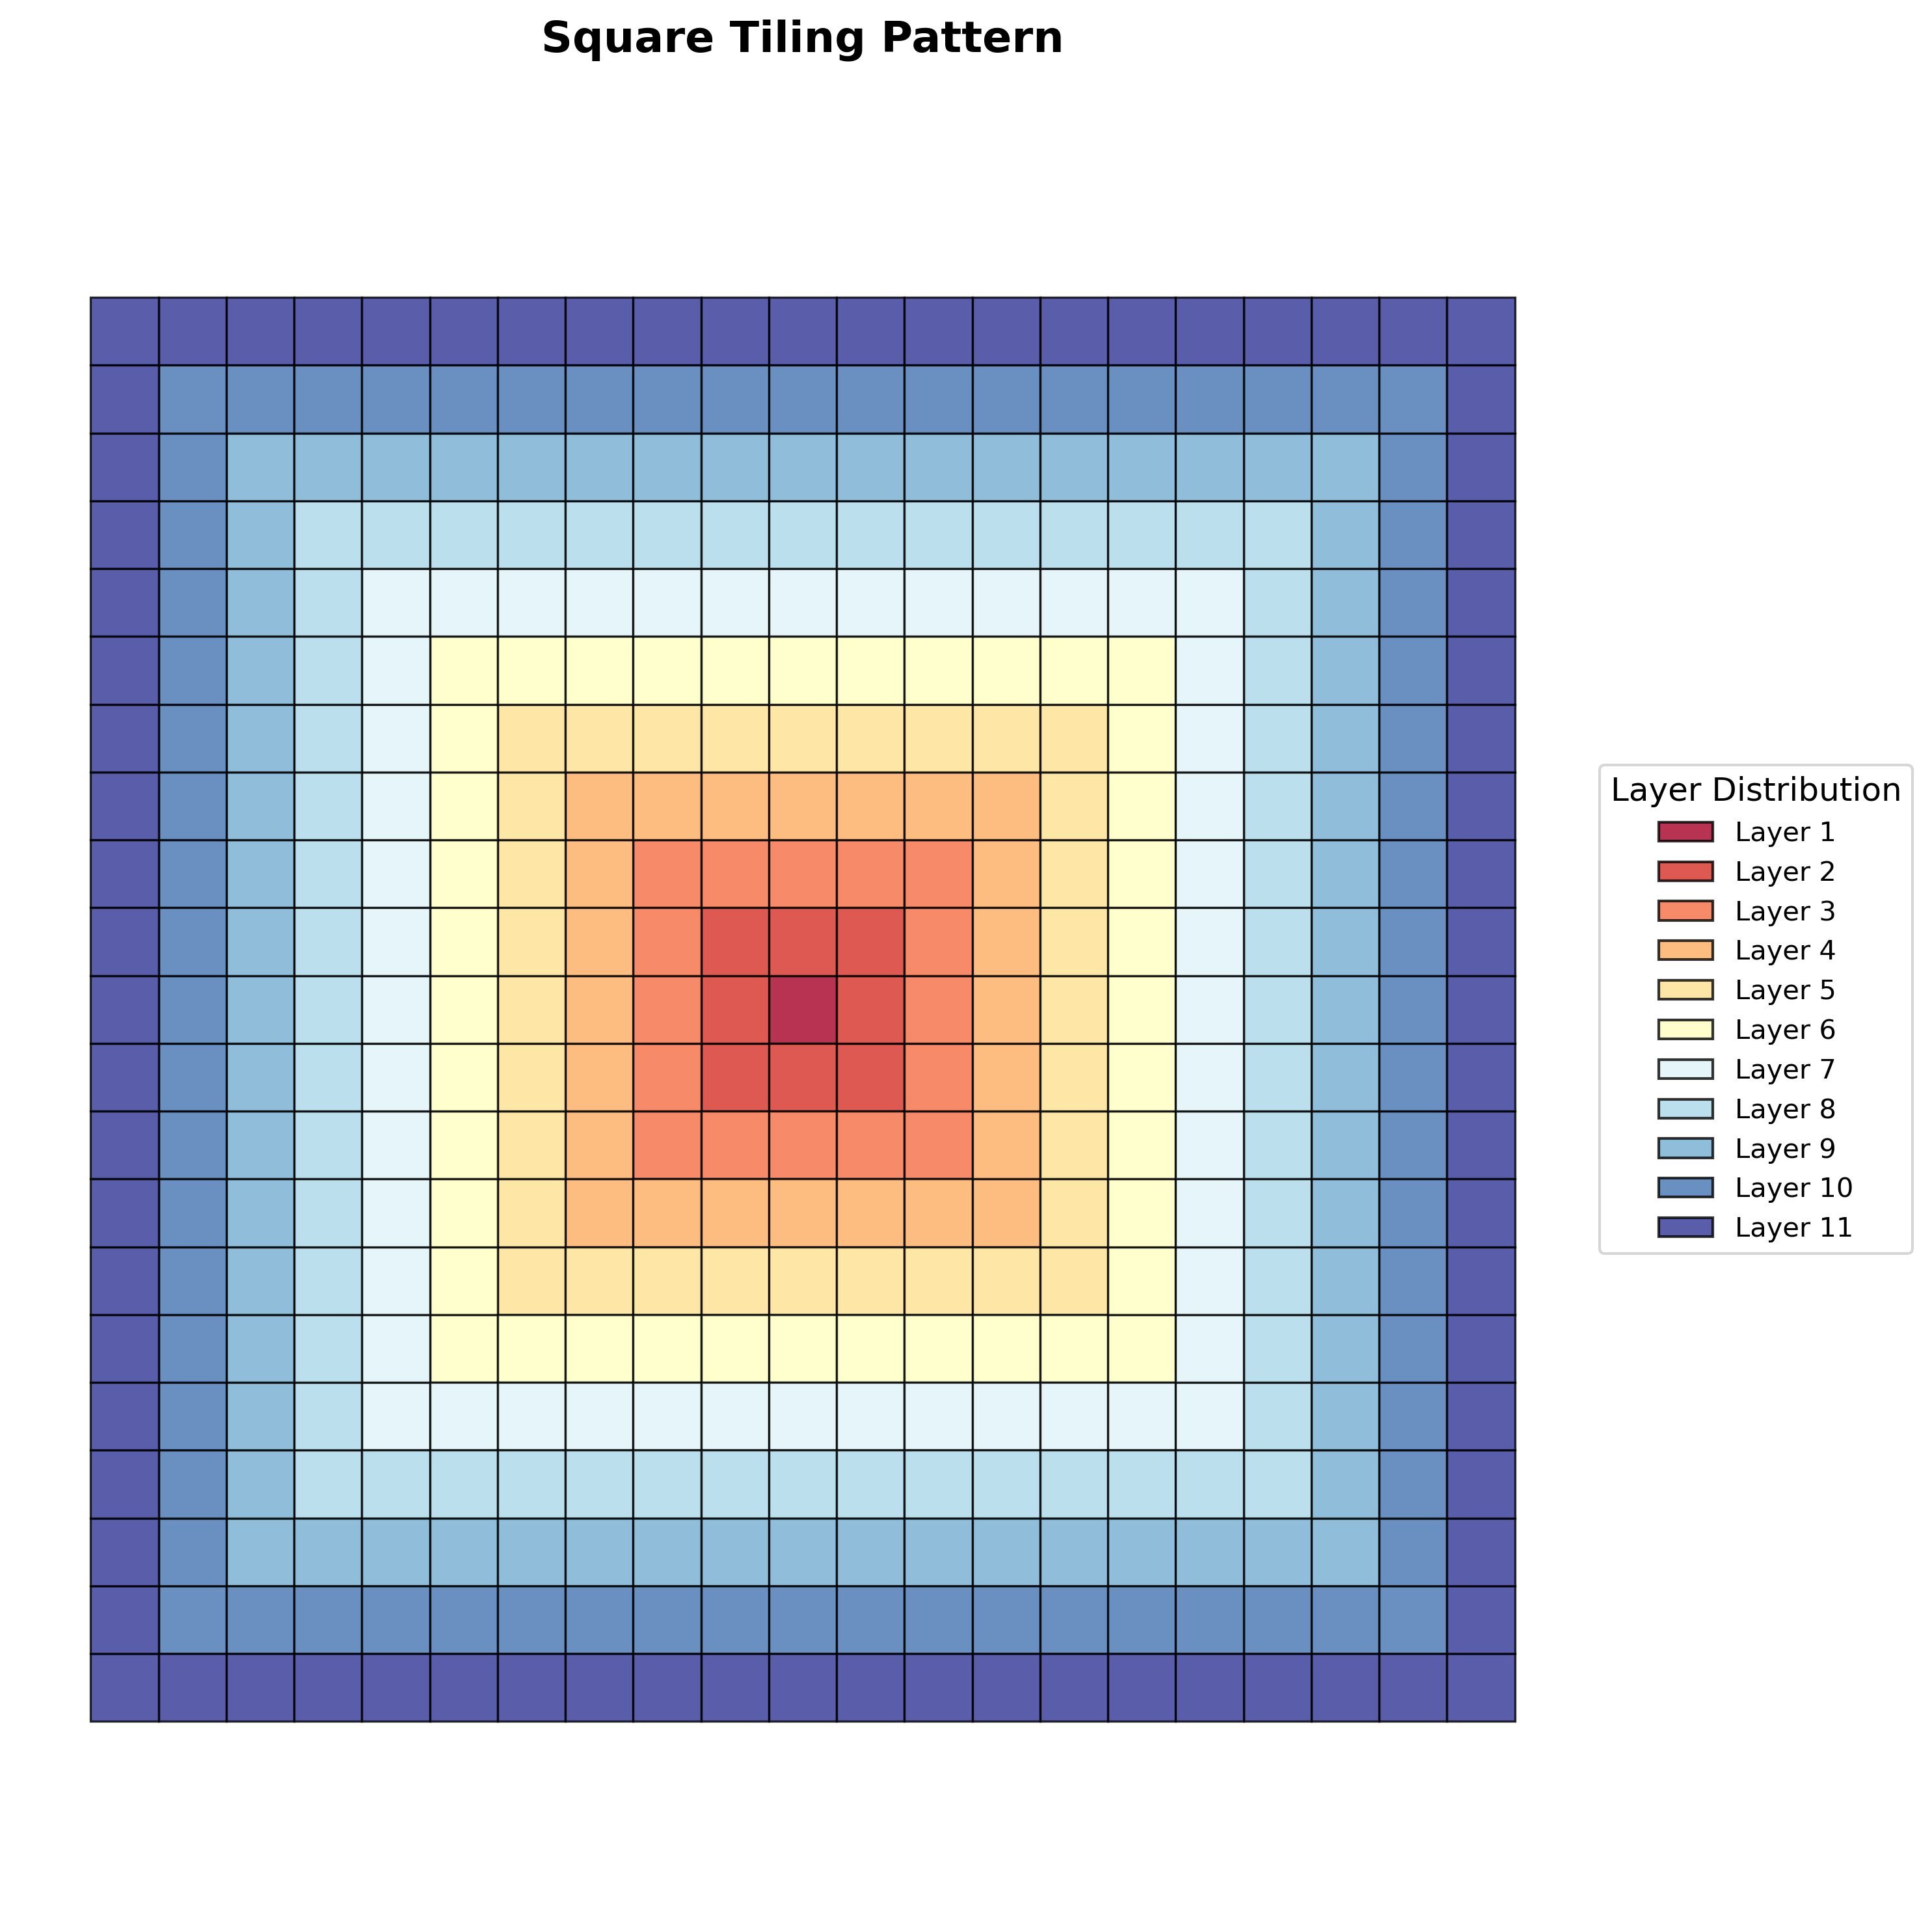

In [4]:
# 采用蒙特卡洛方法从正六边形中心开始，随机向周围扩散2，3个正六边形，并保证形成的形状是不能平铺的
def create_square(side_length=1):
    """Create a single square centered at the origin."""
    points = np.array([
        [side_length/2, side_length/2],
        [-side_length/2, side_length/2],
        [-side_length/2, -side_length/2],
        [side_length/2, -side_length/2]
    ])
    return points

def generate_colored_square_tiling(side_length, layers):
    """Generate a square tiling with a specific color for each layer."""
    squares_by_layer = []
    
    for layer in range(layers + 1):
        layer_squares = []
        if layer == 0:
            # Center square
            layer_squares.append(create_square(side_length))
        else:
            # For each layer, generate complete square layer
            for x in range(-layer, layer + 1):
                for y in range(-layer, layer + 1):
                    if max(abs(x), abs(y)) == layer:
                        x_offset = x * side_length
                        y_offset = y * side_length
                        layer_squares.append(create_square(side_length) + [x_offset, y_offset])
        
        squares_by_layer.append(layer_squares)
    
    return squares_by_layer

def visualize_colored_square_tiling(squares_by_layer):
    """Visualize the square tiling with different colors for each layer."""
    plt.figure(figsize=(10, 10), dpi=300)
    
    colors = plt.cm.RdYlBu(np.linspace(0, 1, len(squares_by_layer)))

    for layer_idx, layer_squares in enumerate(squares_by_layer):
        for square in layer_squares:
            plt.fill(square[:, 0], square[:, 1],
                    color=colors[layer_idx],
                    edgecolor='black',
                    linewidth=0.8,
                    alpha=0.8)

    plt.axis('equal')
    plt.axis('off')
    
    plt.title('Square Tiling Pattern',
              fontsize=16,
              pad=20, 
              fontweight='bold')
    
    legend_elements = [plt.Rectangle((0, 0), 1, 1,
                                   facecolor=colors[i],
                                   edgecolor='black', 
                                   alpha=0.8,
                                   label=f'Layer {i+1}')
                      for i in range(len(squares_by_layer))]
    
    plt.legend(handles=legend_elements,
              loc='center left',
              bbox_to_anchor=(1, 0.5), 
              title='Layer Distribution',
              title_fontsize=12,
              fontsize=10)
    
    plt.tight_layout()
    
    plt.savefig('square_tiling.png',
                dpi=300,
                bbox_inches='tight', 
                pad_inches=0.1)
    
    plt.show()

# Generate square tiling pattern
side_length = 1
layers = 10
squares_by_layer = generate_colored_square_tiling(side_length, layers)

# Visualize results
visualize_colored_square_tiling(squares_by_layer)

